In [2]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from sklearn.cluster import KMeans
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder
import optuna
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

## Preprocessing

Before we can do any analysis, we need to preprocess the data to get it in a form suitable for analysis. We'll need to:

* **Load:** Load the data from CSV files
* **Clean:** Clean the data to fix any errors or inconsistencies
* **Encode:** Encode the statistical data type (numeric, categorical)
* **Impute:** Impute any missing values

### Load

In [3]:
# train path:
train_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
# test path:
test_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
# load train data:
train = pd.read_csv(train_path, index_col='Id')
test = pd.read_csv(test_path, index_col='Id')

In [4]:
# Train data:
display(train.head())
print('Train data contains {} rows and {} features'.format(train.shape[0], train.shape[1]))

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Train data contains 1460 rows and 80 features


In [5]:
display(test.head())
print('Test data contains {} rows and {} features'.format(test.shape[0], test.shape[1]))

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Test data contains 1459 rows and 79 features


### Cleaning

In [6]:
def clean(df) :
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    return df
    
train = clean(train)
test = clean(test)

In [7]:
# Concat test and train data:
all_data = pd.concat([train, test])
all_data.tail(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2910,180,RM,21.0,1470,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,NaN
2911,160,RM,21.0,1484,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,NaN
2912,20,RL,80.0,13384,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,NaN
2913,160,RM,21.0,1533,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,12,2006,WD,Abnorml,NaN
2914,160,RM,21.0,1526,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,NaN
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


### Impute missing values:

When imputing missing values, it’s important to understand that some NaN values in the dataset represent "None" rather than truly missing or null values. These instances occur when the absence of a value has meaning, such as indicating the non-existence of a particular feature.

These Features are : 'PoolQC','BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Alley', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'GarageType', , 'MiscFeature'

In [9]:
# Vsiualize the percentages of missing values per features:
missing_values = pd.DataFrame({'Percentage' : (all_data.isnull().sum()/len(all_data)) * 100}, 
                              index=all_data.columns)
missing_values = missing_values[missing_values['Percentage']>0].sort_values(
    by='Percentage', 
    ascending=False)
missing_values.drop(index='SalePrice', inplace=True)
missing_values.head(10)

,Percentage
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
MasVnrType,60.500171
FireplaceQu,48.646797
LotFrontage,16.649538
GarageCond,5.447071
GarageQual,5.447071
GarageFinish,5.447071


In [11]:
# Replace "Na" null values for these features with "None":
none_features = ['PoolQC','BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu', 'GarageFinish', 
                 'GarageQual', 'GarageCond', 'Fence', 'Alley', 'BsmtFinType1', 'BsmtFinType2', 
                 'MasVnrType', 'GarageType', 'MiscFeature']
for col in none_features:
    all_data[col] = all_data[col].fillna('None')

In [12]:
# Zero imputing missing values:
missing_features_1 = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
                      'BsmtFullBath', 'BsmtHalfBath','GarageArea', 'GarageCars']
for col in missing_features_1:
    all_data[col] = all_data[col].fillna(0)
# Zero imputing with mode:
missing_features_2 = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 
                      'SaleType']
for col in missing_features_2:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# LotFrontage:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
# Functional :
all_data['Functional'] = all_data['Functional'].fillna('Typ')
# Utilities:
all_data.drop('Utilities', axis=1, inplace=True)

In [13]:
# Reform splits
train = all_data.loc[train.index, :]
test = all_data.loc[test.index, :]

### Label Encoding

These models are not highly sensitive to one-hot encoding since they naturally handle categorical variables by splitting them based on their values. Therefore, to simplify the process and reduce dimensionality, we apply label encoding to all the categorical features, ensuring that each category is represented as an **ordinal value** while maintaining the performance of tree-based algorithms.

In [14]:
def label_encoding(df):
    le = LabelEncoder()
    for col in df.select_dtypes(exclude=['number']).columns:
        df[col] = le.fit_transform(df[col])
    return df

## Metric Function
### Target Variable : SalePrice

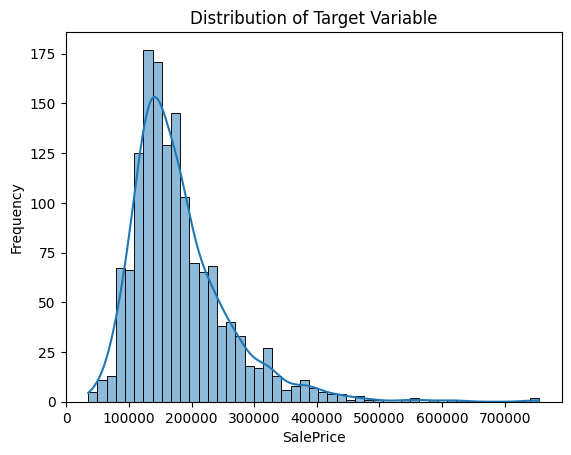

In [15]:
# Distribution of the target variable
sns.histplot(train.SalePrice, kde=True) 
plt.title('Distribution of Target Variable')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

The distribution of the target variable, **SalePrice**, shows significant skewness, indicating that it is not normally distributed. This lack of normality can negatively affect the performance of models that assume a normal distribution for optimal predictions.

To address this, applying a **logarithmic transformation** to the SalePrice variable will help to reduce the skewness and approximate a more normal distribution. 

This transformation will be particularly beneficial when computing metrics in regression models, as it will ensure that errors and predictions are measured in a more balanced manner, leading to better results and model accuracy.

In [16]:
def score_model(X, y, model=XGBRegressor()):
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

### Baseline Score

In [17]:
X = train.copy()
y = X.pop('SalePrice')
X = label_encoding(X)
baseline_score = score_model(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14057 RMSLE


# Feature Correlation

Correlation between numerical features and a target variable is a statistical measure that indicates the strength and direction of a linear relationship between them. In predictive modeling, understanding this correlation is crucial, as it helps identify which features significantly impact the target variable. A strong positive correlation suggests that as one feature increases, the target variable tends to increase as well, while a strong negative correlation indicates that an increase in the feature corresponds to a decrease in the target variable. 

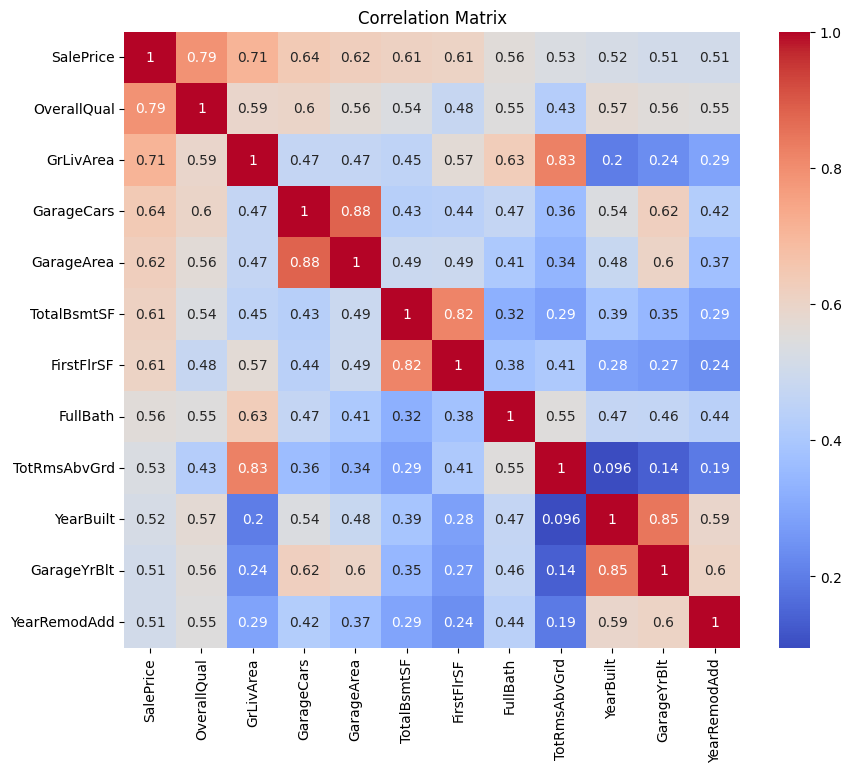

In [18]:
# Calculating correlations :
train_corr = train.select_dtypes(include=[np.number])
corr = train_corr.corr()
# Sorting correlations with SalePrice:
corr_sorted = corr['SalePrice'].abs().sort_values(ascending=False)
corr_high = corr_sorted[corr_sorted>0.5].index
# Subsetting correlations:
corr = corr.loc[corr_high, corr_high]
# Visualize the heatmap:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

## Saleprice correlation matrix with relevant columns

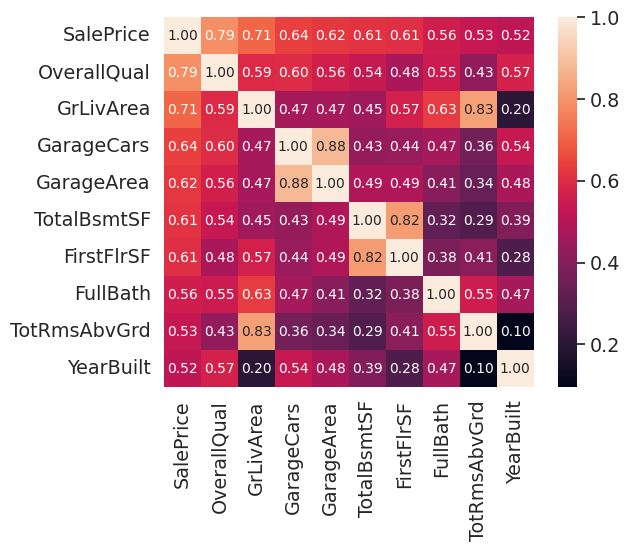

In [22]:
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_corr[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()



OverallQual and GrLivArea have the highest correlation with SalePrice:

* **GrLivArea:** Above grade (ground) living area square feet.
* **GarageCars:** Size of garage in car capacity

The other 6 six variables with a correlation higher than 0.5 with SalePrice are: -TotalBsmtSF: Total square feet of basement area -1stFlrSF: First Floor square feet -FullBath: Full bathrooms above grade -TotRmsAbvGrd: Total rooms above grade (does not include bathrooms) -YearBuilt: Original construction date -YearRemodAdd: Remodel date (same as construction date if no remodeling or additions).

GarageCars and GarageArea have a correlation of 0.89, meaning they move together strongly. It is multicollinearity. Why Multicollinearity is an Issue? When multicollinearity is present:

* **Redundancy:** Both variables are conveying essentially the same information. Including both doesn't add value and might lead to confusing results.
* **Unstable Coefficients:** The regression model may struggle to determine which variable (GarageCars or GarageArea) is more important, leading to unstable coefficient estimates. This means small changes in the data could cause large swings in the coefficients, making the model less reliable.



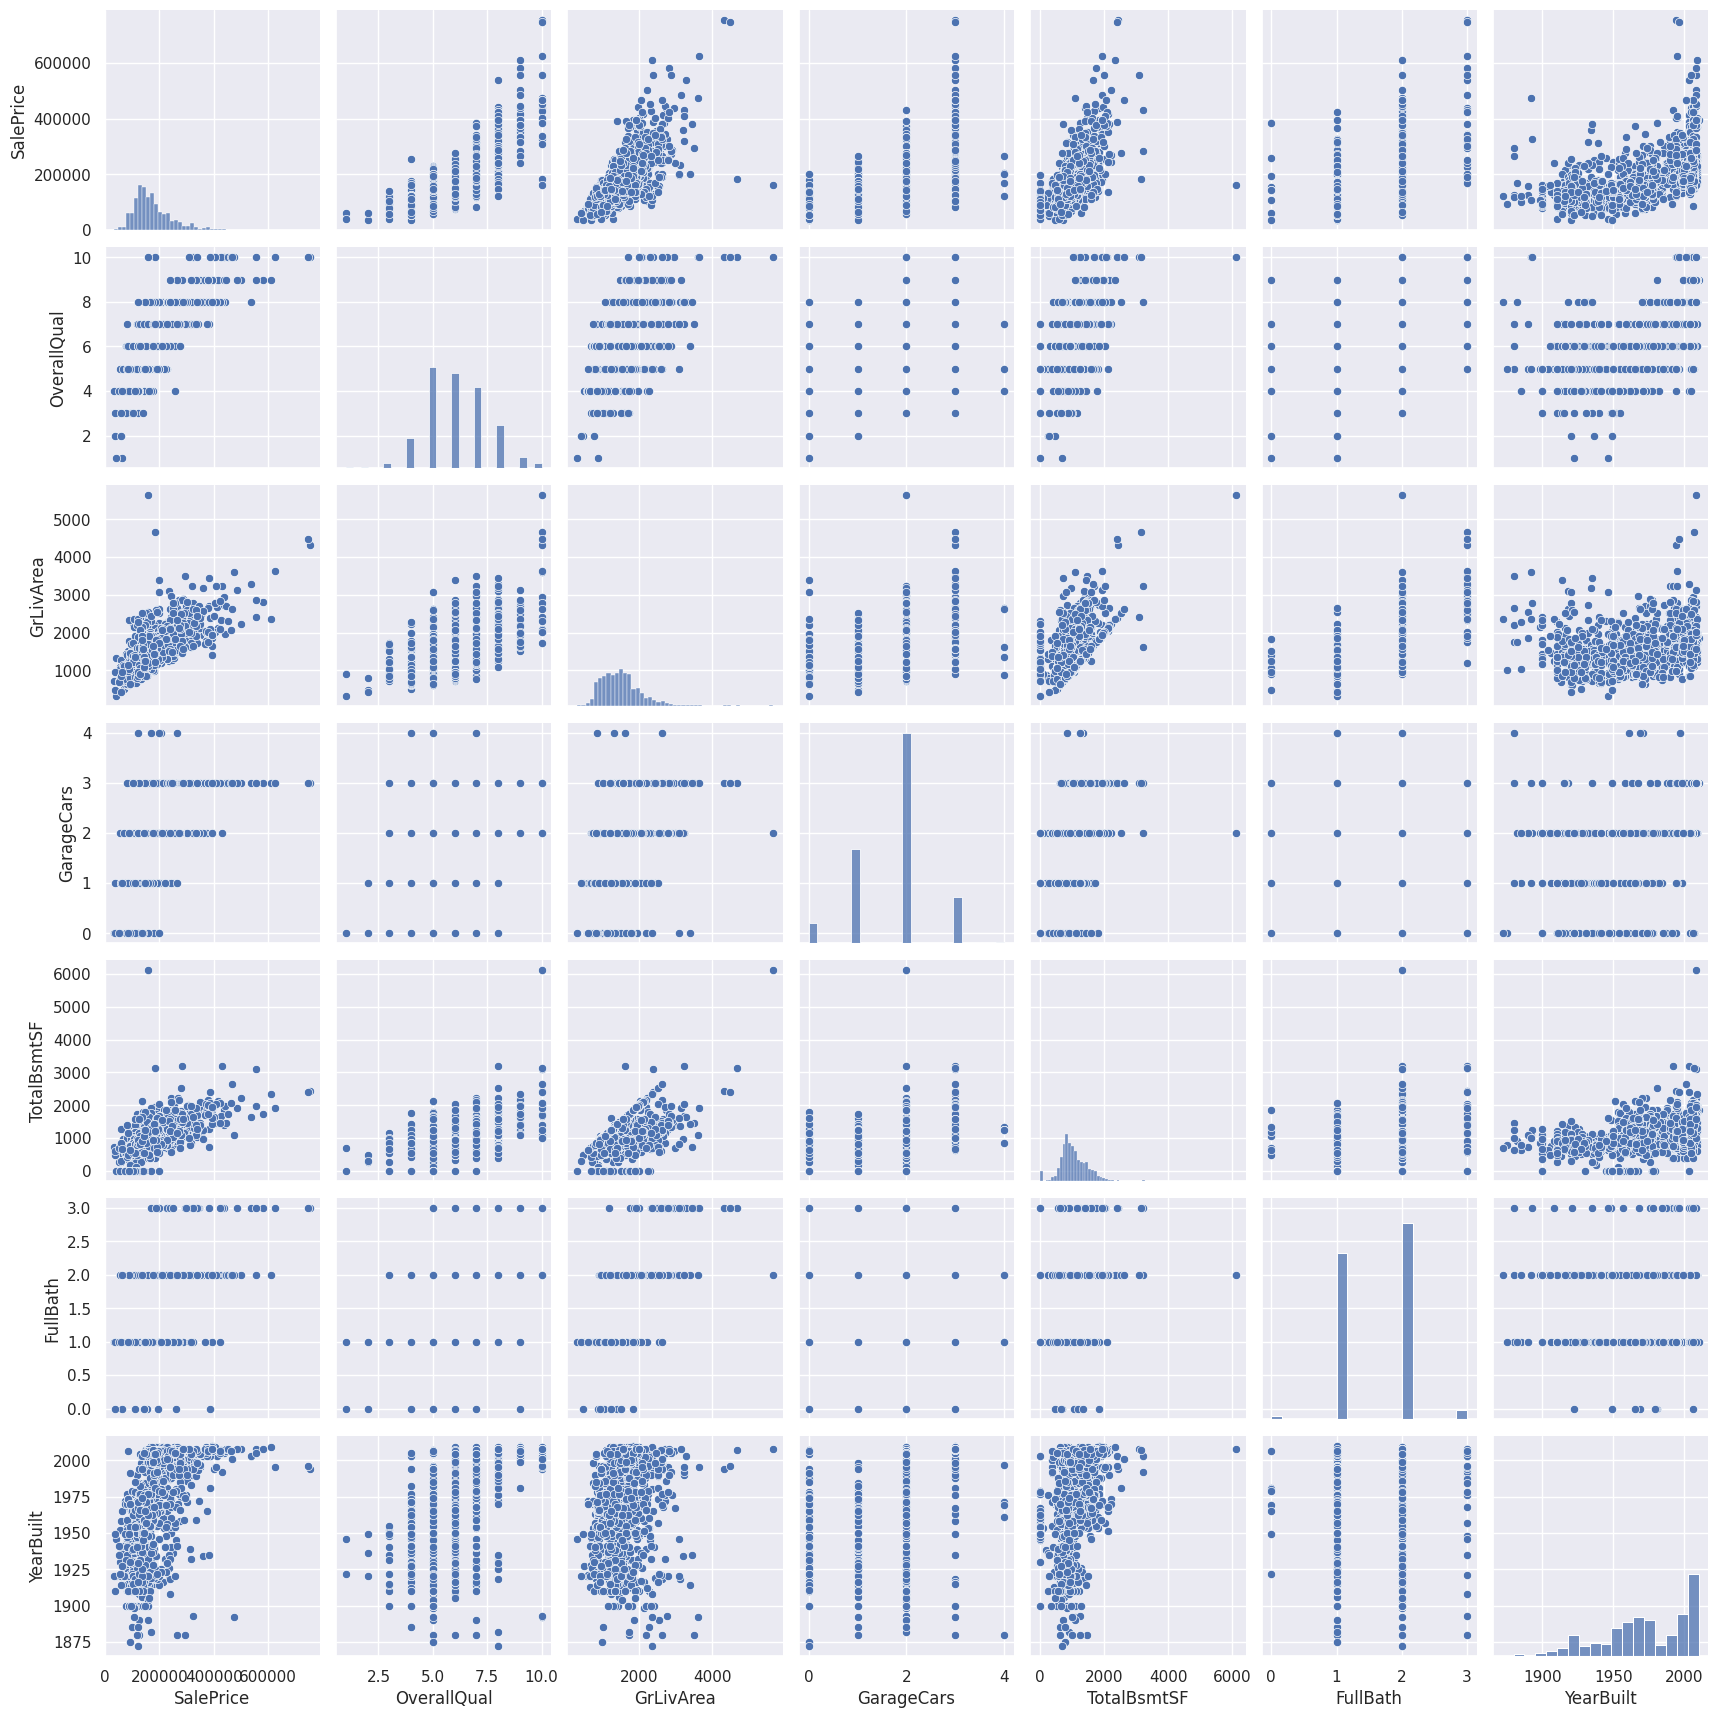

In [23]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

This pair plot helps you explore the pairwise relationships between these variables, allowing you to visually inspect potential correlations, outliers, or patterns that could be useful for your house price prediction model

## Mutual Information

Mutual Information (MI) and correlation both measure relationships between variables, but MI captures both linear and non-linear dependencies, while correlation only detects linear relationships.

Correlation is simple to interpret, ranging from -1 to 1, and works well for continuous numerical data with linear dependencies. MI, on the other hand, can handle both categorical and continuous data, detecting more complex relationships but is less intuitive and computationally more expensive.

In [24]:
# Function to calculate mi_scores:
def make_mi_scores(X, y):
    X = X.copy()
    # Encode categorical features:
    # All discrete features should now have integer dtypes
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # extract discrete features:
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, 
                                      discrete_features=discrete_features,
                                      random_state=0)
    # Store mi scores in a serie
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    # Sort the mi scores
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [25]:
X = train.copy()
y = X.pop('SalePrice')
scores_mi = make_mi_scores(X, y)
display(scores_mi)

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 78, dtype: float64

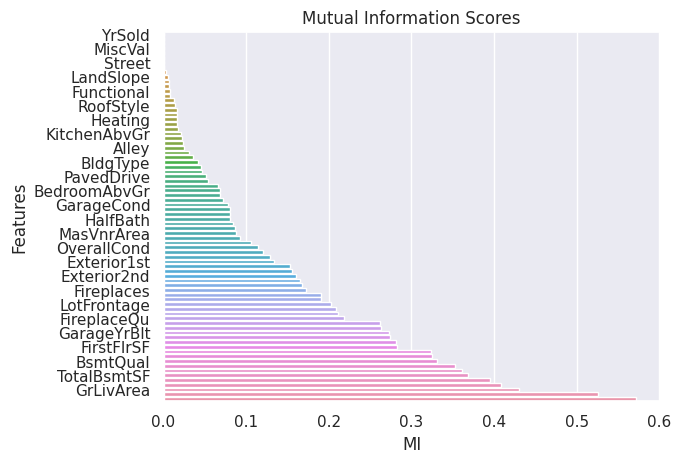

In [26]:
# Function to plot the mi_scores:
def plot_mi_scores(scores):
    # sort the scores:
    scores = scores.sort_values(ascending=True)
    sns.barplot(x=scores, y=scores.index)
    plt.xlabel('MI')
    plt.ylabel('Features')
    plt.title('Mutual Information Scores')
    # Set y-axis tick locations and labels
    tick_locations = range(0, len(scores.index), 3)  # every 2 units
    tick_labels = scores.index[tick_locations]
    plt.yticks(tick_locations, tick_labels)
plot_mi_scores(scores_mi)

**Key takeaways:**

* Features like OverallQual, Neighborhood, GrLivArea are the most important for your house price prediction model.
* Features with 0 mutual information can be candidates for removal, as they do not contribute to predicting the target variable

In [27]:
# Function to drop uninformative features:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [28]:
# Score after droping uninformative features:
X = train.copy()
y = X.pop('SalePrice')
X = drop_uninformative(X, scores_mi)
X = label_encoding(X)
score = score_model(X, y)
print(f"Score: {score:.5f} RMSLE")

Score: 0.14088 RMSLE


# Outliers Detection

Outliers are data points that significantly differ from other observations in a dataset. In the context of house price prediction, these outliers can represent properties with extreme values in terms of price, size, or other features (like luxury mansions or unusually small houses). These can distort the patterns in the data, affecting the performance of machine learning models.

For house price prediction, outliers can skew the model's understanding of the relationship between features and price, potentially leading to poor generalization on unseen data. To address this, techniques such as removing or transforming outliers (using logarithmic scaling or robust statistical methods) are commonly employed. However, the approach to outliers must be carefully chosen so as not to discard valuable information or alter the true nature of the data.



## Scatter Plots

* **Visual Inspection:** By visually inspecting the scatter plots, you can identify points that are far away from the main cluster of points. These points may be outliers.
* **Points far from the regression line:** If you were to draw a regression line on each scatter plot, points that are far away from the line may be considered outliers.
* **Points with unusual x or y values:** If a point has an x or y value that is significantly different from the rest of the data, it may be an outlier

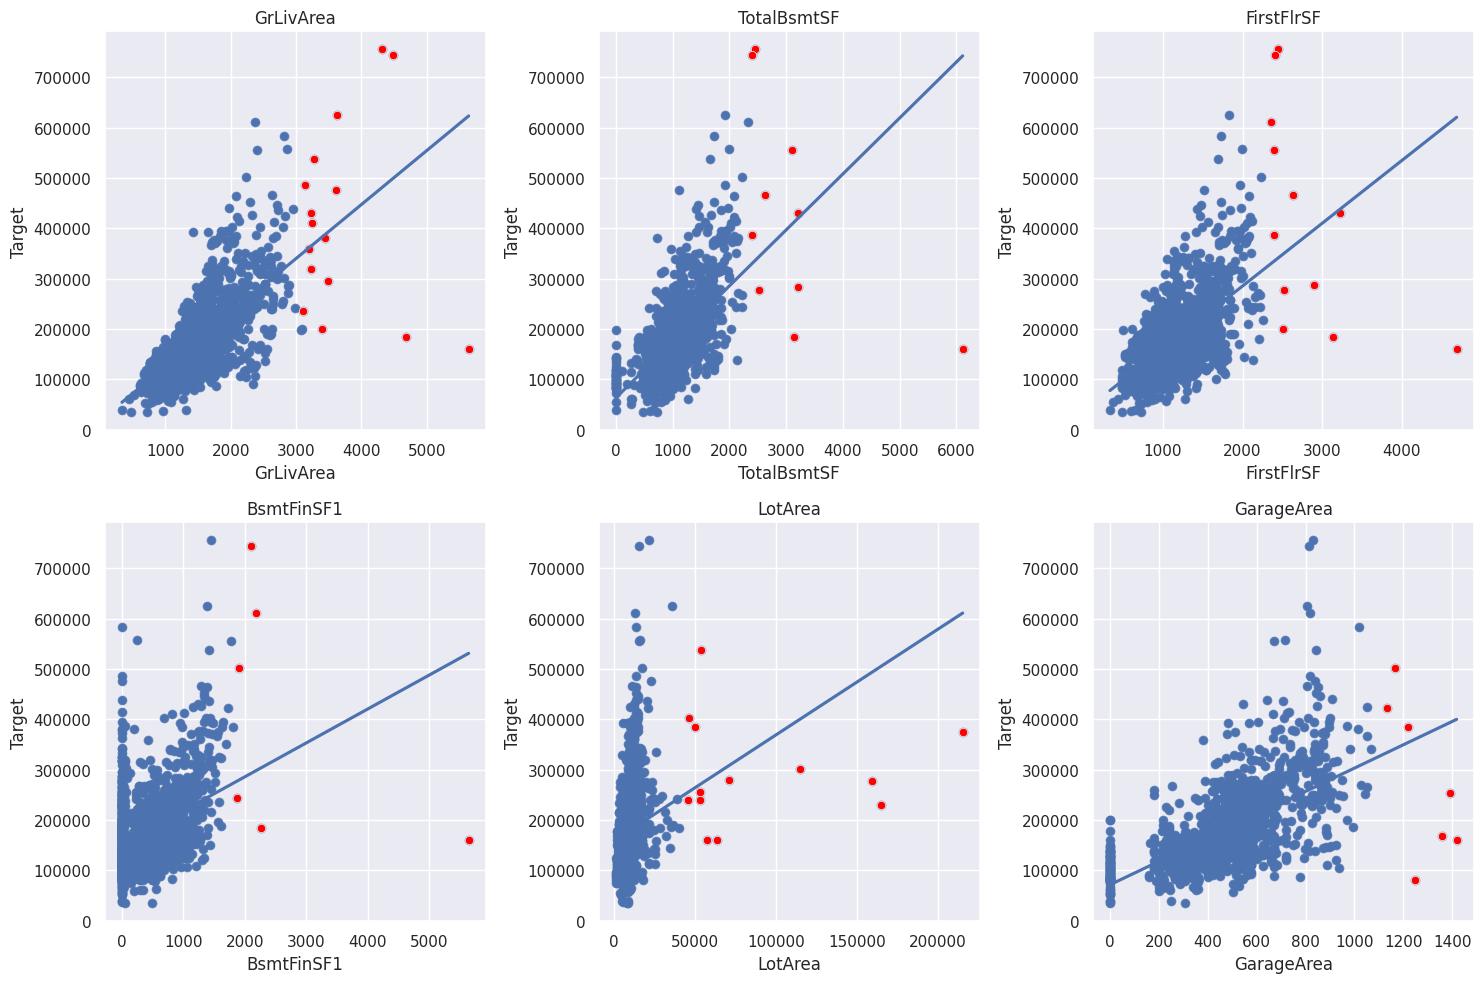

In [29]:

# Define the 6 features
features = ['GrLivArea', 'TotalBsmtSF', 'FirstFlrSF', 'BsmtFinSF1', 'LotArea', 'GarageArea']

# Create a figure and axis object
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop through each feature
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    
    # Create a scatter plot
    sns.scatterplot(x=feature, y='SalePrice', data=train, ax=ax)
    
    # Fit a linear line
    sns.regplot(x=feature, y='SalePrice', data=train, ax=ax, ci=None)
    
    # Identify outliers using Z-score method
    z_scores = np.abs(stats.zscore(train[feature]))
    outliers = train[z_scores > 3]
    
    # Color outliers
    sns.scatterplot(x=feature, y='SalePrice', data=outliers, ax=ax, color='red')
    
    # Set title and labels
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel('Target')

# Show the plot
plt.tight_layout()
plt.show()

## Delete Outliers

In [30]:
def delete_outliers(df):
    df = df[df['GrLivArea'] < 4500]
    df = df[df['LotArea'] < 100000]
    df = df[df['TotalBsmtSF'] < 3000]
    df = df[df['FirstFlrSF'] < 2500]
    df = df[df['BsmtFinSF1'] < 2000]
    return df

In [31]:
# Score after deleting outliers:
X = train.copy()
X = delete_outliers(X)
y = X.pop('SalePrice')
X = drop_uninformative(X, scores_mi)
X = label_encoding(X)
score = score_model(X, y)
print(f"Score: {score:.5f} RMSLE")

Score: 0.13694 RMSLE


After observing a score decrease from 0.14088 to 0.13694, it became evident that deleting outliers had a **positive impact** on the model's performance. This improvement demonstrates that removing anomalous data points can enhance the model's ability to generalize, leading to a more accurate prediction of house prices.

# Feature Engineering
## Create Features

I will focus on creating new features by exploring relationships between existing features. This includes generating features through mathematical operations such as ratios, differences, and sums, as well as incorporating counts and group-based aggregations. 

These engineered features aim to capture additional insights and patterns that may improve the predictive power of the model.

In [32]:
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X
def interesting_features(df):
    X= pd.DataFrame()
    X['BsmtFinType1_Unf'] = 1*(df['BsmtFinType1'] == 'Unf')
    X['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']
    X['TotalSF'] = df['TotalBsmtSF'] + df["FirstFlrSF"] + df["SecondFlrSF"]
    X['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
    X['YearsSinceRemodel'] = df['YrSold'].astype(int) - df['YearRemodAdd'].astype(int)
    X['Total_sqr_footage'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df["FirstFlrSF"] + df["SecondFlrSF"])
    X['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    X['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    X['has2ndfloor'] = df['SecondFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    X['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    X['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    X['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    return X
def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X
def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X
def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X
def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

In [33]:
# Score after creating new features:
X = train.copy()
X = delete_outliers(X)
y = X.pop('SalePrice')
X = X.join(interesting_features(X))
X = X.join(mathematical_transforms(X))
X = X.join(interactions(X))
X = X.join(counts(X))
X = X.join(group_transforms(X))
X = label_encoding(X)
score = score_model(X, y)
print(f"Score: {score:.5f} RMSLE")

Score: 0.13128 RMSLE


## Kmeans Clustering

We will implement KMeans clustering to group similar patterns in certain features of the dataset. By identifying clusters, we aim to assign labels that reflect these groupings, adding valuable information to our analysis.

In [34]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [35]:
# Score after creating new features:
X = train.copy()
X = delete_outliers(X)
y = X.pop('SalePrice')
X = X.join(interesting_features(X))
X = X.join(mathematical_transforms(X))
X = X.join(interactions(X))
X = X.join(counts(X))
X = X.join(group_transforms(X))
X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
X = label_encoding(X)
score = score_model(X, y)
print(f"Score: {score:.5f} RMSLE")

Score: 0.13344 RMSLE


## PCA

The principal components are essentially new, engineered features that combine information from your original features. These new features may capture patterns that are not evident in the original feature set

Benefit: Adding X_pca could introduce new, informative features that your model can leverage, improving prediction accuracy by giving it access to transformed, high-variance components

In [36]:
# Apply pca to a df:
def apply_pca(X, standarize=True):
    # Standarize the features for applying pca if you need:
    if standarize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create a pca:
    pca = PCA()
    # fit and transform the features:
    X_pca = pca.fit_transform(X)
    # Convert X_pca to df:
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names) 
    # Create Loading :
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [37]:
# Function to return the pca components of some features: 
def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca

In [38]:
# Score after creating PCA components:
X = train.copy()
X = delete_outliers(X)
y = X.pop('SalePrice')
X = X.join(interesting_features(X))
X = X.join(mathematical_transforms(X))
X = X.join(interactions(X))
X = X.join(counts(X))
X = X.join(group_transforms(X))
pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]
X = X.join(pca_components(X, pca_features))
X = label_encoding(X)
score = score_model(X, y)
print(f"Score: {score:.5f} RMSLE")

Score: 0.13236 RMSLE


## Target Encoding

Target encoding is a technique used in machine learning that encodes categorical variables by replacing each category with a number derived from the target variable, rather than simply converting categories into numerical values as seen in methods like one-hot encoding or label encoding.

This approach involves calculating the mean (or another statistical measure) of the target variable for each category, thus capturing the relationship between the category and the target.

By doing so, target encoding can provide a more informative representation of categorical features, often leading to improved model performance, particularly in scenarios with high-cardinality categorical variables.

In [39]:
# Lets identify the features with the high cardinality variables :
nominal_features = ["MSSubClass", "MSZoning", "Street", "Alley", "LotConfig", "Neighborhood", 
                    "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", 
                    "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", 
                    "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]
cardinality = train[nominal_features].nunique().sort_values(ascending=False)
print(cardinality)

Neighborhood     25
Exterior2nd      16
MSSubClass       15
Exterior1st      15
SaleType          9
Condition1        9
HouseStyle        8
RoofMatl          8
Condition2        8
GarageType        7
RoofStyle         6
Foundation        6
Heating           6
SaleCondition     6
BldgType          5
MSZoning          5
LotConfig         5
MiscFeature       5
MasVnrType        4
Alley             3
CentralAir        2
Street            2
dtype: int64


There is, however, a way you can use target encoding without having to use held-out encoding data. It's basically the same trick used in cross-validation:

* Split the data into folds, each fold having two splits of the dataset.
* Train the encoder on one split but transform the values of the other.
* Repeat for all the splits.



In [40]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [41]:
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"])
X_encoded.head()


,MSSubClass_encoded
Id,
1,237921.022113
2,180993.404066
3,237921.022113
4,166597.420056
5,237921.022113


## Create Final Set of Features

In [42]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Mutual Information
    # X = drop_uninformative(X, mi_scores)

    # Transformations
    X = X.join(interesting_features(X))
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # PCA
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encoding(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["Neighborhood"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X





In [43]:
X = train.copy()
X_train = create_features(X)
y_train = X.loc[:, "SalePrice"]
score = score_model(X_train, y_train)
print(f"Score: {score:.5f} RMSLE")

Score: 0.13740 RMSLE



# Hyperparamater Tuning

In this section, we will focus on hyperparameter tuning for our models. Hyperparameter tuning is essential to optimize the performance of our machine learning algorithms by selecting the best set of parameters for each model. By fine-tuning these parameters, we aim to improve the predictive accuracy and efficiency of our models in the house price prediction task.

## Xgboost


In [44]:
# Choose Manually variables:
X = train.copy()
X_train = create_features(X)
y_train = X.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=7,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=3000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=2,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score = score_model(X_train, y_train, xgb)
print(f"Score: {score:.5f} RMSLE")

Score: 0.12536 RMSLE


## Tuning With Optuna

In [45]:
X = train.copy()
X_train = create_features(X)
y_train = X.loc[:, "SalePrice"]

xgb_params = {'max_depth': 6,
 'learning_rate': 0.0054327375927544245,
 'n_estimators': 3860,
 'min_child_weight': 3,
 'colsample_bytree': 0.2460611837296628,
 'subsample': 0.27927638624844453,
 'reg_alpha': 0.028227088223601027,
 'reg_lambda': 0.015803764385717418}

xgb_tuned = XGBRegressor(**xgb_params)
score = score_model(X_train, y_train, xgb_tuned)
print(f"Score: {score:.5f} RMSLE")

Score: 0.11790 RMSLE
